# Introduction

## Objectif du Notebook

L'objectif de ce notebook est de développer un **modèle d'analyse de sentiments classique** en utilisant des techniques d'apprentissage automatique traditionnelles, comme la **régression logistique**. Ce modèle sera appliqué à un jeu de données de tweets, et nous comparerons les performances avec et sans pré-traitement des données (lemmatisation et stemming).

## Présentation de la Méthode Simple

Dans ce notebook, nous allons utiliser un modèle de **régression logistique**, qui est un algorithme de classification supervisé simple mais efficace. L'idée est de transformer les tweets en représentations numériques à l'aide de **CountVectorizer** ou de **TF-IDF** (Term Frequency-Inverse Document Frequency), puis d'entraîner le modèle à prédire le sentiment d'un tweet.

### Régression Logistique

La régression logistique est un modèle de classification binaire qui prédit une probabilité qu'un exemple appartienne à une classe donnée (par exemple, un tweet positif ou négatif). Elle est simple à interpréter et rapide à entraîner, ce qui en fait un bon point de départ pour ce projet.

### Pré-traitement des Données (Lemmatisation et Stemming)

Pour améliorer les performances du modèle, nous allons tester deux approches de pré-traitement :
- **Lemmatisation** : Réduire les mots à leur forme canonique (ex. "manger" au lieu de "mange", "mangé", "mangent").
- **Stemming** : Réduire les mots à leur racine (ex. "mang" pour "manger", "mange", "mangé").

Nous comparerons également l'utilisation de ces pré-traitements avec l'utilisation de données brutes (sans pré-traitement) afin d'identifier la méthode la plus efficace.

## Plan du Notebook

1. **Chargement et Préparation des Données** : Chargement des tweets, nettoyage des textes et préparation des données sous forme brute, lemmatisée et stemmée.
2. **Vecteurisation des Textes** : Utilisation de **CountVectorizer** et de **TF-IDF** pour transformer les textes en vecteurs de caractéristiques.
3. **Construction du Modèle de Régression Logistique** : Définition d'un modèle simple de régression logistique pour la classification de sentiments.
4. **Entraînement du Modèle** : Entraînement du modèle sur les différentes versions des données (lemmatisé, et stemmé).
5. **Évaluation du Modèle** : Calcul des performances du modèle (précision, rappel, F1-score) pour chaque version des données.
6. **Export du Meilleur Modèle** : Sauvegarde et export du modèle le plus performant pour une utilisation future dans une API de prédiction.


# 1. Importation des Bibliothèques

In [2]:
# Importation des bibliothèques nécessaires
import mlflow
import mlflow.sklearn
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk

# Assurez-vous que les ressources NLTK nécessaires sont téléchargées
nltk.download('punkt')
nltk.download('wordnet')

# Initialisation de MLFlow (sans tracking inutile)
mlflow.set_tracking_uri("file:./mlflow/modele_simple")  # Sauvegarde dans un dossier au-dessus du notebook
mlflow.set_experiment("sentiment_analysis_experiment")

# Charger les données déjà prétraitées
data = pd.read_csv('../data/database_p7_rework.csv')

# Initialisation du scaler pour les données (sparse)
scaler = StandardScaler(with_mean=False)  # `with_mean=False` est utilisé car les données sont sparse

# Afficher les premières lignes pour vérification (pas nécessaire dans le tracking)
data.head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\trist\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\trist\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2024/10/14 09:05:52 INFO mlflow.tracking.fluent: Experiment with name 'sentiment_analysis_experiment' does not exist. Creating a new experiment.


,target,id,date,flag,user,text,year,month,word_count,hour,sentiment,text_cleaned,text_lemmatized,text_stemmed
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009,4,19,22,0.216667,switchfoot http twitpic com 2y1zl awww that s...,switchfoot http twitpic com 2y1zl awww that s ...,switchfoot http twitpic com 2y1zl awww that s ...
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,2009,4,21,22,0.000000,is upset that he can t update his facebook by ...,is upset that he can t update his facebook by ...,is upset that he can t updat hi facebook by te...
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,2009,4,18,22,0.500000,kenichan i dived many times for the ball mana...,kenichan i dived many time for the ball manage...,kenichan i dive mani time for the ball manag t...
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,2009,4,10,22,0.200000,my whole body feels itchy and like its on fire,my whole body feel itchy and like it on fire,my whole bodi feel itchi and like it on fire
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",2009,4,21,22,-0.625000,nationwideclass no it s not behaving at all i...,nationwideclass no it s not behaving at all i ...,nationwideclass no it s not behav at all i m m...


# 2. Vectorisation et Séparation des Données

In [4]:
# Échantillonnage équilibré pour avoir autant de classes 0 que 1
sample_data = data.groupby('target', group_keys=False).apply(lambda x: x.sample(min(len(x), 8000), random_state=42))

# Séparation des données en ensemble d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    sample_data[['text_lemmatized', 'text_stemmed']],  # Colonnes des textes lemmatisés et stemmés
    sample_data['target'],                             # Labels
    test_size=0.2,                                     # 20% pour le test
    random_state=42,                                   # Pour la reproductibilité
    stratify=sample_data['target']                     # Assurer un échantillonnage équilibré
)

# Transformation des labels en binaire (4 devient 1)
y_train = y_train.map({4: 1, 0: 0})
y_test = y_test.map({4: 1, 0: 0})

# Ajouter une colonne indiquant si c'est train ou test
X_train['set'] = 'train'
X_test['set'] = 'test'

# Fusionner les ensembles d'entraînement et de test
X_simple = pd.concat([X_train, X_test])
X_simple['target'] = pd.concat([y_train, y_test]).values  # Ajouter les labels transformés

# Sauvegarder toutes les données dans un seul fichier CSV
X_simple.to_csv('./split_donnees/x_simple.csv', index=False)

# Vérification des formes
print(f"x_simple shape: {X_simple.shape}")


x_simple shape: (16000, 4)


In [5]:
# Charger les données fusionnées (x_simple.csv)
X_simple = pd.read_csv('./split_donnees/x_simple.csv')

# Séparer les données en fonction de la colonne 'set' (train/test)
X_train = X_simple[X_simple['set'] == 'train']
X_test = X_simple[X_simple['set'] == 'test']

## 2.1 Lemmatisation + CountVectorizer

In [7]:
# Lemmatisation + CountVectorizer
count_vectorizer = CountVectorizer()

# Vectoriser uniquement la colonne lemmatisée
X_train_count_lemma = count_vectorizer.fit_transform(X_train['text_lemmatized'])
X_test_count_lemma = count_vectorizer.transform(X_test['text_lemmatized'])

# Appliquer le scaler sur les données vectorisées
scaler = StandardScaler(with_mean=False)  # Les données sont sparse
X_train_count_lemma = scaler.fit_transform(X_train_count_lemma)
X_test_count_lemma = scaler.transform(X_test_count_lemma)

# Récupérer les labels (target)
y_train_lemma = X_train['target']
y_test_lemma = X_test['target']

# Vérification des formes des matrices
print(f"X_train_count_lemma shape: {X_train_count_lemma.shape}, X_test_count_lemma shape: {X_test_count_lemma.shape}")

import scipy.sparse
# Sauvegarde des matrices vectorisées dans le dossier ./matrice/
scipy.sparse.save_npz('./matrice/X_train_count_lemma.npz', X_train_count_lemma)
scipy.sparse.save_npz('./matrice/X_test_count_lemma.npz', X_test_count_lemma)

X_train_count_lemma shape: (12800, 21087), X_test_count_lemma shape: (3200, 21087)


## 2.2 Lemmatisation + TF-IDF

In [9]:
# Lemmatisation + TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Vectoriser uniquement la colonne lemmatisée
X_train_tfidf_lemma = tfidf_vectorizer.fit_transform(X_train['text_lemmatized'])
X_test_tfidf_lemma = tfidf_vectorizer.transform(X_test['text_lemmatized'])

# Appliquer le scaler sur les données vectorisées
scaler = StandardScaler(with_mean=False)  # Les données sont sparse
X_train_tfidf_lemma = scaler.fit_transform(X_train_tfidf_lemma)
X_test_tfidf_lemma = scaler.transform(X_test_tfidf_lemma)

# Sauvegarde des matrices vectorisées dans le dossier ./matrice/
scipy.sparse.save_npz('./matrice/X_train_tfidf_lemma.npz', X_train_tfidf_lemma)
scipy.sparse.save_npz('./matrice/X_test_tfidf_lemma.npz', X_test_tfidf_lemma)

# Vérification des formes des matrices
print(f"X_train_tfidf_lemma shape: {X_train_tfidf_lemma.shape}, X_test_tfidf_lemma shape: {X_test_tfidf_lemma.shape}")

X_train_tfidf_lemma shape: (12800, 21087), X_test_tfidf_lemma shape: (3200, 21087)


## 2.3 Lemmatisation + CountVectorizer + TF-IDF

In [11]:
# Lemmatisation + CountVectorizer + TF-IDF
count_vectorizer = CountVectorizer()

# Vectoriser uniquement la colonne lemmatisée
X_train_count_lemma = count_vectorizer.fit_transform(X_train['text_lemmatized'])
X_test_count_lemma = count_vectorizer.transform(X_test['text_lemmatized'])

# Appliquer le TF-IDF Transformer
tfidf_transformer = TfidfTransformer()
X_train_count_tfidf_lemma = tfidf_transformer.fit_transform(X_train_count_lemma)
X_test_count_tfidf_lemma = tfidf_transformer.transform(X_test_count_lemma)

# Appliquer le scaler sur les données vectorisées
scaler = StandardScaler(with_mean=False)  # Les données sont sparse
X_train_count_tfidf_lemma = scaler.fit_transform(X_train_count_tfidf_lemma)
X_test_count_tfidf_lemma = scaler.transform(X_test_count_tfidf_lemma)

# Sauvegarde des matrices vectorisées dans le dossier ./matrice/
scipy.sparse.save_npz('./matrice/X_train_count_tfidf_lemma.npz', X_train_count_tfidf_lemma)
scipy.sparse.save_npz('./matrice/X_test_count_tfidf_lemma.npz', X_test_count_tfidf_lemma)

# Vérification des formes des matrices
print(f"X_train_count_tfidf_lemma shape: {X_train_count_tfidf_lemma.shape}, X_test_count_tfidf_lemma shape: {X_test_count_tfidf_lemma.shape}")

X_train_count_tfidf_lemma shape: (12800, 21087), X_test_count_tfidf_lemma shape: (3200, 21087)


## 2.4 Stemming + CountVectorizer

In [13]:
# Stemming + CountVectorizer
count_vectorizer = CountVectorizer()

# Vectoriser uniquement la colonne stemmée
X_train_count_stem = count_vectorizer.fit_transform(X_train['text_stemmed'])
X_test_count_stem = count_vectorizer.transform(X_test['text_stemmed'])

# Appliquer le scaler sur les données vectorisées
scaler = StandardScaler(with_mean=False)  # Les données sont sparse
X_train_count_stem = scaler.fit_transform(X_train_count_stem)
X_test_count_stem = scaler.transform(X_test_count_stem)

# Sauvegarde des matrices vectorisées dans le dossier ./matrice/
scipy.sparse.save_npz('./matrice/X_train_count_stem.npz', X_train_count_stem)
scipy.sparse.save_npz('./matrice/X_test_count_stem.npz', X_test_count_stem)

# Vérification des formes des matrices
print(f"X_train_count_stem shape: {X_train_count_stem.shape}, X_test_count_stem shape: {X_test_count_stem.shape}")

X_train_count_stem shape: (12800, 19260), X_test_count_stem shape: (3200, 19260)


## 2.5 Stemming + TF-IDF

In [15]:
# Stemming + TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Vectoriser uniquement la colonne stemmée
X_train_tfidf_stem = tfidf_vectorizer.fit_transform(X_train['text_stemmed'])
X_test_tfidf_stem = tfidf_vectorizer.transform(X_test['text_stemmed'])

# Appliquer le scaler sur les données vectorisées
scaler = StandardScaler(with_mean=False)  # Les données sont sparse
X_train_tfidf_stem = scaler.fit_transform(X_train_tfidf_stem)
X_test_tfidf_stem = scaler.transform(X_test_tfidf_stem)

# Sauvegarde des matrices vectorisées dans le dossier ./matrice/
scipy.sparse.save_npz('./matrice/X_train_tfidf_stem.npz', X_train_tfidf_stem)
scipy.sparse.save_npz('./matrice/X_test_tfidf_stem.npz', X_test_tfidf_stem)

# Vérification des formes des matrices
print(f"X_train_tfidf_stem shape: {X_train_tfidf_stem.shape}, X_test_tfidf_stem shape: {X_test_tfidf_stem.shape}")

X_train_tfidf_stem shape: (12800, 19260), X_test_tfidf_stem shape: (3200, 19260)


## 2.6 Stemming + CountVectorizer + TF-IDF

In [17]:
# Stemming + CountVectorizer + TF-IDF
count_vectorizer = CountVectorizer()

# Vectoriser uniquement la colonne stemmée
X_train_count_stem = count_vectorizer.fit_transform(X_train['text_stemmed'])
X_test_count_stem = count_vectorizer.transform(X_test['text_stemmed'])

# Appliquer le TF-IDF Transformer
tfidf_transformer = TfidfTransformer()
X_train_count_tfidf_stem = tfidf_transformer.fit_transform(X_train_count_stem)
X_test_count_tfidf_stem = tfidf_transformer.transform(X_test_count_stem)

# Appliquer le scaler sur les données vectorisées
scaler = StandardScaler(with_mean=False)  # Les données sont sparse
X_train_count_tfidf_stem = scaler.fit_transform(X_train_count_tfidf_stem)
X_test_count_tfidf_stem = scaler.transform(X_test_count_tfidf_stem)

# Sauvegarde des matrices vectorisées dans le dossier ./matrice/
scipy.sparse.save_npz('./matrice/X_train_count_tfidf_stem.npz', X_train_count_tfidf_stem)
scipy.sparse.save_npz('./matrice/X_test_count_tfidf_stem.npz', X_test_count_tfidf_stem)

# Vérification des formes des matrices
print(f"X_train_count_tfidf_stem shape: {X_train_count_tfidf_stem.shape}, X_test_count_tfidf_stem shape: {X_test_count_tfidf_stem.shape}")

X_train_count_tfidf_stem shape: (12800, 19260), X_test_count_tfidf_stem shape: (3200, 19260)


# 3. Entraînement des Modèles de Régression Logistique

In [71]:
import time
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse

def train_and_log_model_best(X_train, X_test, y_train, y_test, experiment_name, model_name):
    """
    Entraîne une régression logistique avec GridSearchCV et capture uniquement les résultats des meilleurs hyperparamètres avec MLFlow.
    Ajoute les métriques : précision, rappel, F1-score et loggue les meilleurs hyperparamètres ainsi que le temps d'entraînement.
    """
    # Paramètres pour la GridSearch sans 'lbfgs'
    param_grid = {
        'C': [0.01, 1, 10],
        'max_iter': [5000, 7500, 10000, 12500],
        'solver': ['liblinear', 'saga']  # Suppression de 'lbfgs'
    }

    # Scaling des données
    scaler = StandardScaler(with_mean=False)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression()

    # GridSearch avec 5-fold cross-validation
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1)

    # Définir l'expérience MLFlow avec le nom du modèle
    mlflow.set_experiment(experiment_name)

    # Initialisation de MLFlow pour capturer le run
    with mlflow.start_run(run_name=model_name):
        start_time = time.time()

        # Entraînement du modèle
        grid_search.fit(X_train_scaled, y_train)
        training_time = time.time() - start_time

        # Meilleurs hyperparamètres trouvés
        best_params = grid_search.best_params_
        
        # Logguer les hyperparamètres dans MLFlow
        mlflow.log_param("best_C", best_params['C'])
        mlflow.log_param("best_max_iter", best_params['max_iter'])
        mlflow.log_param("best_solver", best_params['solver'])

        # Logguer le temps d'entraînement dans MLFlow
        mlflow.log_metric("training_time", training_time)

        # Sauvegarde du modèle
        mlflow.sklearn.log_model(grid_search.best_estimator_, model_name)

        # Prédiction
        y_pred = grid_search.best_estimator_.predict(X_test_scaled)
        y_pred_proba = grid_search.best_estimator_.predict_proba(X_test_scaled)[:, 1]

        # Calcul des métriques
        accuracy = accuracy_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Enregistrement des métriques dans MLFlow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("auc", auc_score)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)

        # Générer et sauvegarder la courbe ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="best")
        roc_curve_path = f"roc_curve_{model_name}.png"  # Enlever './matrice/'
        plt.savefig(roc_curve_path)
        mlflow.log_artifact(roc_curve_path)

        # Générer et sauvegarder la matrice de confusion
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Prédictions')
        plt.ylabel('Vérités')
        plt.title("Matrice de Confusion")
        conf_matrix_path = f"conf_matrix_{model_name}.png"  # Enlever './matrice/'
        plt.savefig(conf_matrix_path)
        mlflow.log_artifact(conf_matrix_path)

        # Affichage des métriques et des meilleurs hyperparamètres dans le terminal
        print(f"Modèle {model_name} enregistré avec les meilleures performances.")
        print(f"Meilleurs hyperparamètres : C = {best_params['C']}, max_iter = {best_params['max_iter']}, solver = {best_params['solver']}")
        print(f"Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
        print(f"Temps d'entraînement: {training_time:.2f} secondes.")


# 4. Entrainement des modèles

## 4.1 Entraînement pour Lemmatisation + CountVectorizer

Traceback (most recent call last):
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 327, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 421, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1367, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1360, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^

Fitting 5 folds for each of 24 candidates, totalling 120 fits


2024/10/14 10:06:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle Run_Lemmatisation_CountVectorizer enregistré avec les meilleures performances.
Meilleurs hyperparamètres : C = 0.01, max_iter = 7500, solver = saga
Accuracy: 0.7081, AUC: 0.7691, Precision: 0.7275, Recall: 0.6656, F1-score: 0.6952
Temps d'entraînement: 292.97 secondes.


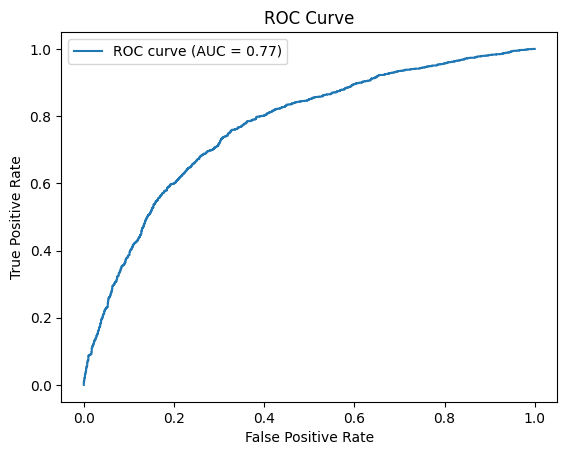

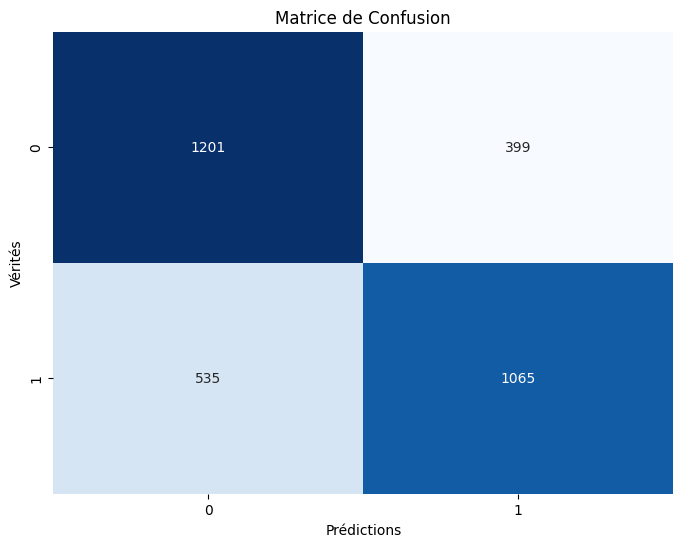

In [74]:
# Charger les matrices vectorisées pour Lemmatisation + CountVectorizer
import scipy.sparse

X_train_count_lemma = scipy.sparse.load_npz('./matrice/X_train_count_lemma.npz')
X_test_count_lemma = scipy.sparse.load_npz('./matrice/X_test_count_lemma.npz')

# Assurez-vous que les labels sont également chargés
y_train_lemma = X_train['target']
y_test_lemma = X_test['target']

# Appeler la fonction pour entraîner le modèle et capturer les résultats dans MLFlow
train_and_log_model_best(X_train_count_lemma, X_test_count_lemma, y_train_lemma, y_test_lemma, "lemm_count", "Run_Lemmatisation_CountVectorizer")


## 4.2 Entraînement pour Lemmatisation + TF-IDF

Traceback (most recent call last):
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 327, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 421, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1367, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1360, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^

Fitting 5 folds for each of 24 candidates, totalling 120 fits


2024/10/14 10:10:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle Run_Lemmatisation_TFIDF enregistré avec les meilleures performances.
Meilleurs hyperparamètres : C = 0.01, max_iter = 10000, solver = saga
Accuracy: 0.6984, AUC: 0.7679, Precision: 0.7158, Recall: 0.6581, F1-score: 0.6858
Temps d'entraînement: 253.53 secondes.


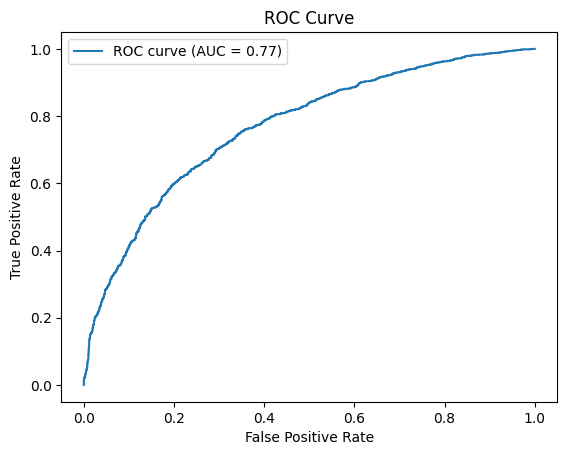

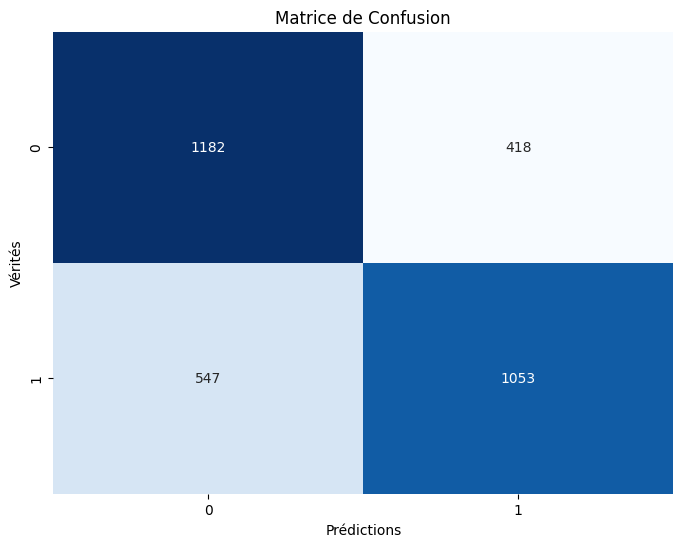

In [76]:
# Charger les matrices vectorisées pour Lemmatisation + TF-IDF
import scipy.sparse

X_train_tfidf_lemma = scipy.sparse.load_npz('./matrice/X_train_tfidf_lemma.npz')
X_test_tfidf_lemma = scipy.sparse.load_npz('./matrice/X_test_tfidf_lemma.npz')

# Assurez-vous que les labels sont également chargés
y_train_lemma = X_train['target']
y_test_lemma = X_test['target']

# Appeler la fonction pour entraîner le modèle et capturer les résultats dans MLFlow
train_and_log_model_best(X_train_tfidf_lemma, X_test_tfidf_lemma, y_train_lemma, y_test_lemma, "lemm_tfidf", "Run_Lemmatisation_TFIDF")


## 4.3 Entraînement pour Lemmatisation + CountVectorizer + TF-IDF

Traceback (most recent call last):
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 327, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 421, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1367, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1360, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^

Fitting 5 folds for each of 24 candidates, totalling 120 fits


2024/10/14 10:14:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle Run_Lemmatisation_CountVectorizer_TFIDF enregistré avec les meilleures performances.
Meilleurs hyperparamètres : C = 0.01, max_iter = 10000, solver = saga
Accuracy: 0.6987, AUC: 0.7679, Precision: 0.7163, Recall: 0.6581, F1-score: 0.6860
Temps d'entraînement: 254.66 secondes.


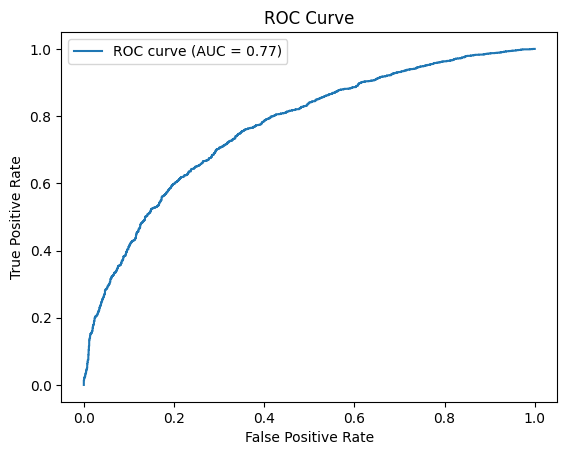

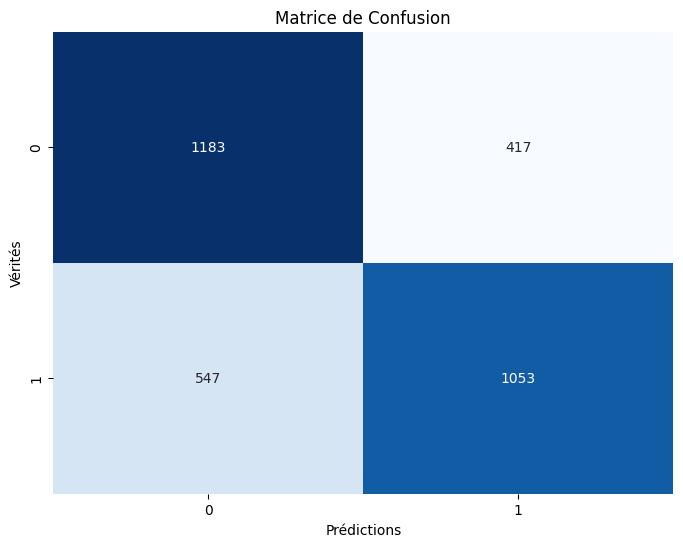

In [78]:
# Charger les matrices vectorisées pour Lemmatisation + CountVectorizer + TF-IDF
import scipy.sparse

X_train_count_tfidf_lemma = scipy.sparse.load_npz('./matrice/X_train_count_tfidf_lemma.npz')
X_test_count_tfidf_lemma = scipy.sparse.load_npz('./matrice/X_test_count_tfidf_lemma.npz')

# Assurez-vous que les labels sont également chargés
y_train_lemma = X_train['target']
y_test_lemma = X_test['target']

# Appeler la fonction pour entraîner le modèle et capturer les résultats dans MLFlow
train_and_log_model_best(X_train_count_tfidf_lemma, X_test_count_tfidf_lemma, y_train_lemma, y_test_lemma, "lemm_count_tfidf", "Run_Lemmatisation_CountVectorizer_TFIDF")


## 4.4 Entraînement pour Stemming + CountVectorizer

Traceback (most recent call last):
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 327, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 421, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1367, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1360, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^

Fitting 5 folds for each of 24 candidates, totalling 120 fits


2024/10/14 10:19:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle Run_Stemming_CountVectorizer enregistré avec les meilleures performances.
Meilleurs hyperparamètres : C = 0.01, max_iter = 5000, solver = liblinear
Accuracy: 0.7022, AUC: 0.7606, Precision: 0.7152, Recall: 0.6719, F1-score: 0.6929
Temps d'entraînement: 311.05 secondes.


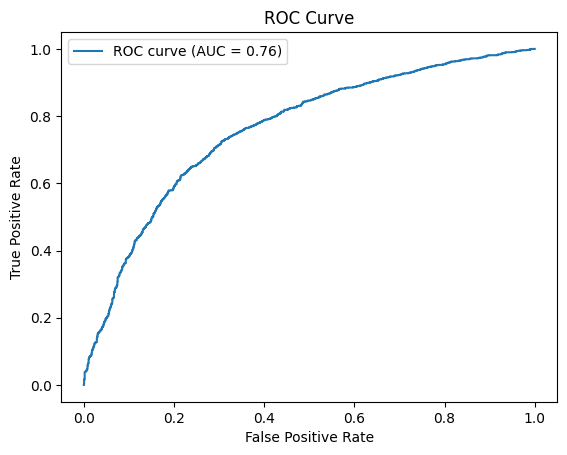

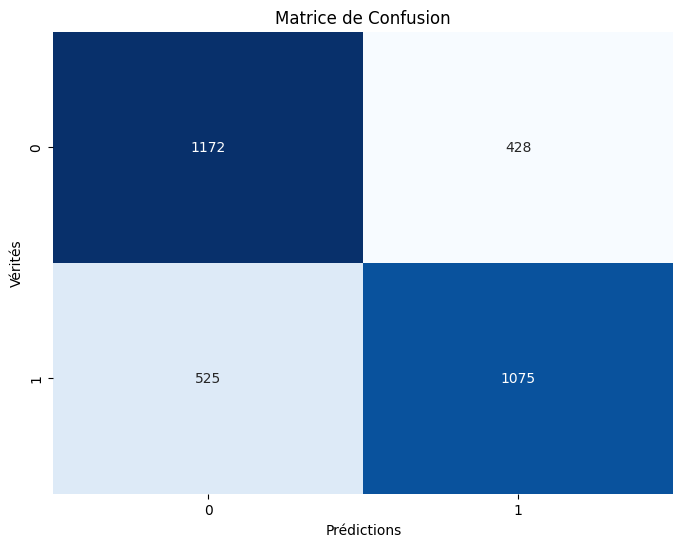

In [80]:
# Charger les matrices vectorisées pour Stemming + CountVectorizer
import scipy.sparse

X_train_count_stem = scipy.sparse.load_npz('./matrice/X_train_count_stem.npz')
X_test_count_stem = scipy.sparse.load_npz('./matrice/X_test_count_stem.npz')

# Assurez-vous que les labels sont également chargés
y_train_stem = X_train['target']
y_test_stem = X_test['target']

# Appeler la fonction pour entraîner le modèle et capturer les résultats dans MLFlow
train_and_log_model_best(X_train_count_stem, X_test_count_stem, y_train_stem, y_test_stem, "stem_count", "Run_Stemming_CountVectorizer")


## 4.5 Entraînement pour Stemming + TF-IDF

Traceback (most recent call last):
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 327, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 421, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1367, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1360, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^

Fitting 5 folds for each of 24 candidates, totalling 120 fits


2024/10/14 10:24:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle Run_Stemming_TFIDF enregistré avec les meilleures performances.
Meilleurs hyperparamètres : C = 0.01, max_iter = 10000, solver = saga
Accuracy: 0.6984, AUC: 0.7607, Precision: 0.7110, Recall: 0.6687, F1-score: 0.6892
Temps d'entraînement: 284.36 secondes.


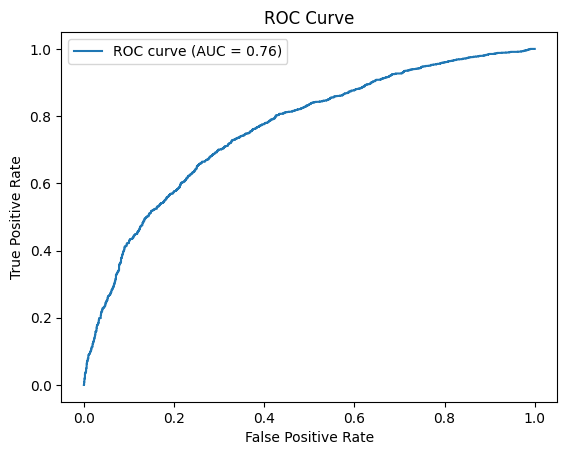

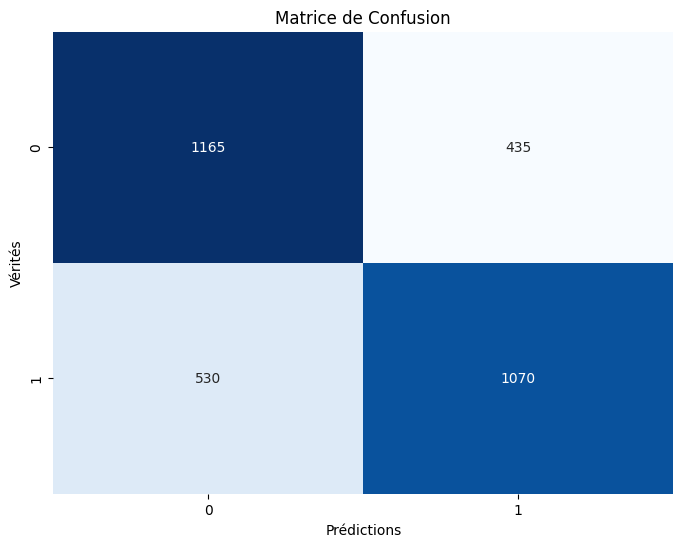

In [82]:
# Charger les matrices vectorisées pour Stemming + TF-IDF
import scipy.sparse

X_train_tfidf_stem = scipy.sparse.load_npz('./matrice/X_train_tfidf_stem.npz')
X_test_tfidf_stem = scipy.sparse.load_npz('./matrice/X_test_tfidf_stem.npz')

# Assurez-vous que les labels sont également chargés
y_train_stem = X_train['target']
y_test_stem = X_test['target']

# Appeler la fonction pour entraîner le modèle et capturer les résultats dans MLFlow
train_and_log_model_best(X_train_tfidf_stem, X_test_tfidf_stem, y_train_stem, y_test_stem, "stem_tfidf", "Run_Stemming_TFIDF")


## 4.6 Entraînement pour Stemming + CountVectorizer + TF-IDF

Traceback (most recent call last):
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 327, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 421, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1367, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1360, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^

Fitting 5 folds for each of 24 candidates, totalling 120 fits


2024/10/14 10:29:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle Run_Stemming_CountVectorizer_TFIDF enregistré avec les meilleures performances.
Meilleurs hyperparamètres : C = 0.01, max_iter = 5000, solver = saga
Accuracy: 0.6984, AUC: 0.7607, Precision: 0.7110, Recall: 0.6687, F1-score: 0.6892
Temps d'entraînement: 282.81 secondes.


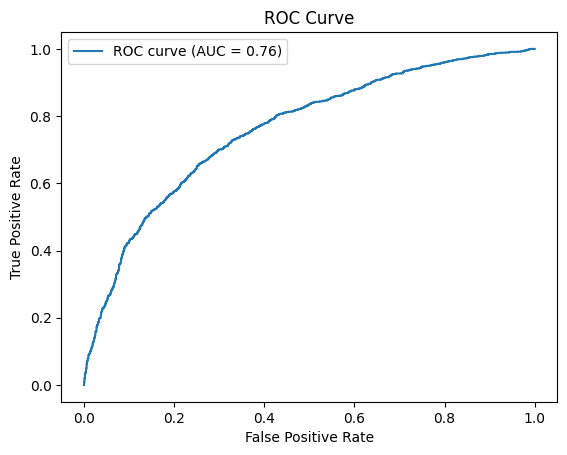

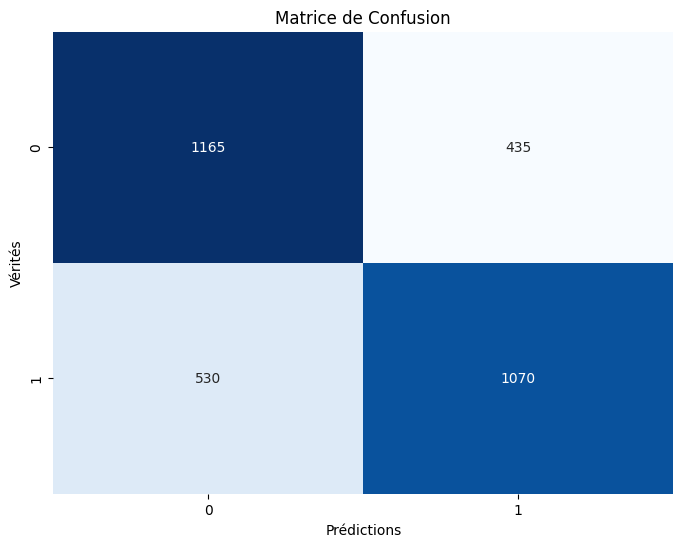

In [84]:
# Charger les matrices vectorisées pour Stemming + CountVectorizer + TF-IDF
import scipy.sparse

X_train_count_tfidf_stem = scipy.sparse.load_npz('./matrice/X_train_count_tfidf_stem.npz')
X_test_count_tfidf_stem = scipy.sparse.load_npz('./matrice/X_test_count_tfidf_stem.npz')

# Assurez-vous que les labels sont également chargés
y_train_stem = X_train['target']
y_test_stem = X_test['target']

# Appeler la fonction pour entraîner le modèle et capturer les résultats dans MLFlow
train_and_log_model_best(X_train_count_tfidf_stem, X_test_count_tfidf_stem, y_train_stem, y_test_stem, "stem_count_tfidf", "Run_Stemming_CountVectorizer_TFIDF")


# 5. Analyse des Résultats

In [86]:
import mlflow
import pandas as pd

# Liste des noms d'expériences à analyser
experiment_names = ["lemm_count", "lemm_tfidf", "lemm_count_tfidf", 
                    "stem_count", "stem_tfidf", "stem_count_tfidf"]

# Initialiser une liste pour stocker les DataFrames de chaque expérimentation
metrics_list = []

# Parcourir chaque expérience pour récupérer les résultats
for experiment_name in experiment_names:
    # Obtenir l'ID de l'expérience à partir du nom
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    # Récupérer les runs de l'expérience
    runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    
    # Créer un DataFrame pour les runs
    runs_df = pd.DataFrame(runs)
    
    # Filtrer dynamiquement les colonnes qui existent
    available_columns = runs_df.columns
    selected_columns = ['run_id', 'metrics.accuracy', 'metrics.auc', 
                        'metrics.precision', 'metrics.recall', 'metrics.f1_score',
                        'metrics.training_time',  # Ajouter la colonne du temps d'exécution
                        'params.best_C', 'params.best_max_iter', 'params.best_solver']  # Hyperparamètres loggués directement dans MLFlow
    
    # Ne garder que les colonnes disponibles
    selected_columns = [col for col in selected_columns if col in available_columns]
    
    # Sélectionner les colonnes présentes
    runs_df = runs_df[selected_columns]
    
    # Ajouter une colonne pour identifier l'expérimentation
    runs_df['experiment'] = experiment_name
    
    # Ajouter les résultats de cette expérience à la liste
    metrics_list.append(runs_df)

# Combiner tous les résultats en un seul tableau
all_metrics_df = pd.concat(metrics_list, ignore_index=True)

# Afficher le tableau avec les hyperparamètres et le temps d'exécution inclus
from IPython.display import display
display(all_metrics_df)


Traceback (most recent call last):
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 327, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 421, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1367, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1360, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^

,run_id,metrics.accuracy,metrics.auc,metrics.precision,metrics.recall,metrics.f1_score,metrics.training_time,params.best_C,params.best_max_iter,params.best_solver,experiment
0,5de6560c824c4fa0b970dca00efb0111,0.708125,0.769066,0.727459,0.665625,0.695170,292.966893,0.01,7500,saga,lemm_count
1,1b1e6e1ea0ac4116ac5f663447806ec4,0.708125,0.769064,0.727459,0.665625,0.695170,NaN,None,None,None,lemm_count
2,627059214e264d168dd590f995a53d15,0.708125,0.769064,0.727459,0.665625,0.695170,NaN,None,None,None,lemm_count
3,19e1d973ffeb4d94bfc239787da38e34,0.698438,0.767927,0.715840,0.658125,0.685770,253.534837,0.01,10000,saga,lemm_tfidf
4,ce343ca53b744872a6efea3c6070421c,0.698750,0.767890,0.716327,0.658125,0.685993,254.660621,0.01,10000,saga,lemm_count_tfidf
5,6f5381ee54d24ab29fa664e454f284ca,0.702187,0.760641,0.715236,0.671875,0.692878,311.048686,0.01,5000,liblinear,stem_count
6,316c6ddf09e742539e1fc3f6655e6aa2,0.698438,0.760742,0.710963,0.668750,0.689211,284.359129,0.01,10000,saga,stem_tfidf
7,65b4d3eb9f7f42bc96b52816565a2306,0.698438,0.760727,0.710963,0.668750,0.689211,282.813589,0.01,5000,saga,stem_count_tfidf


Traceback (most recent call last):
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 327, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 421, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1367, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1360, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^

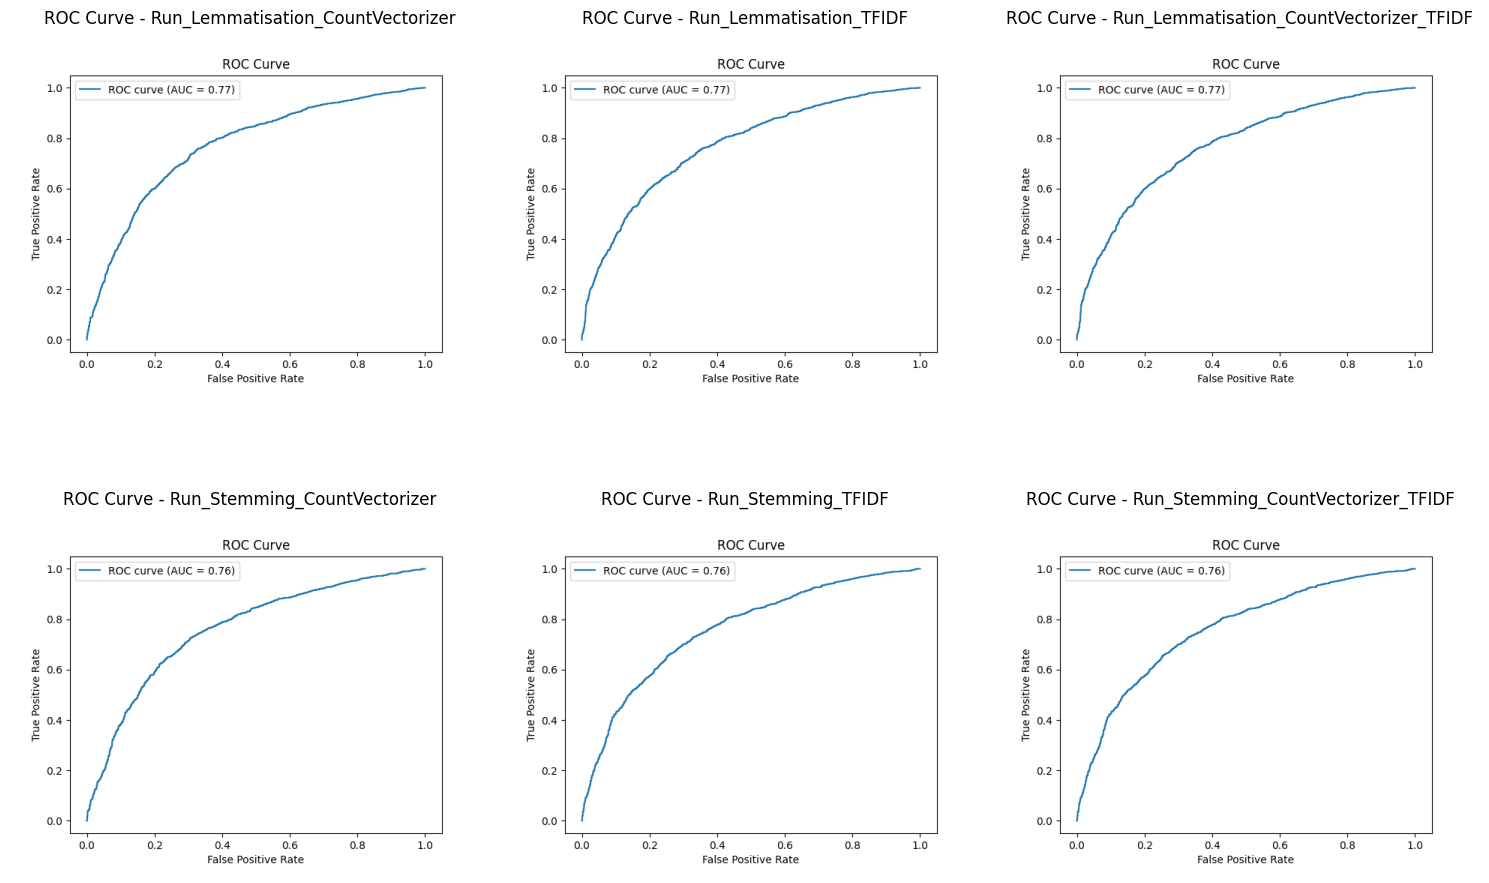

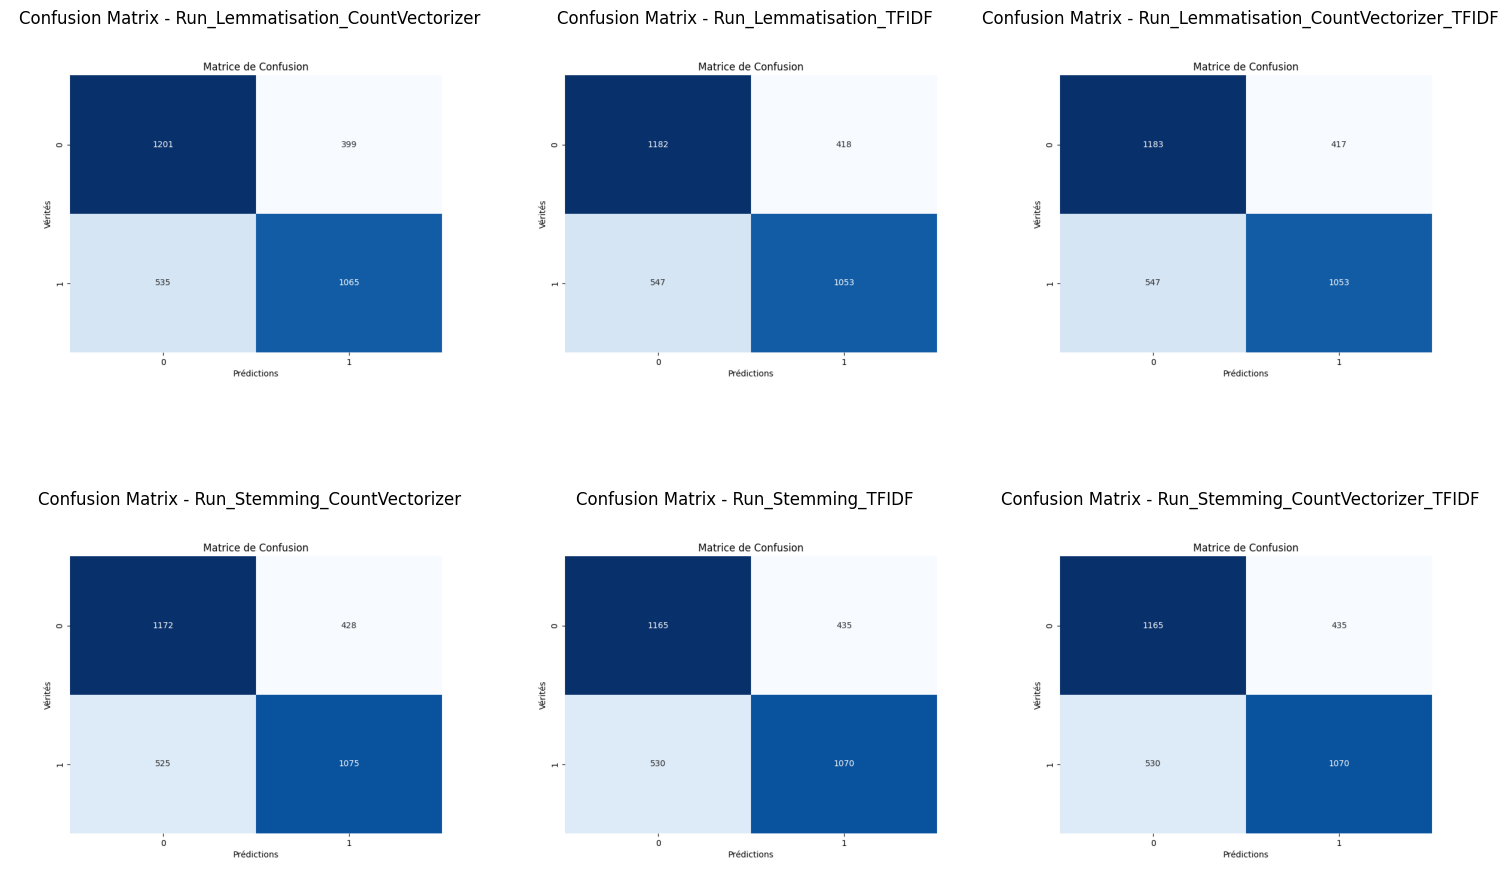

In [87]:
import mlflow
from PIL import Image
import matplotlib.pyplot as plt

# Fonction pour télécharger les artefacts
def download_artifacts_for_run(run_id, experiment_name, model_name):
    client = mlflow.tracking.MlflowClient()

    # Télécharger la courbe ROC
    try:
        roc_curve_path = client.download_artifacts(run_id, f"./roc_curve_{model_name}.png")
    except Exception as e:
        print(f"Erreur lors de la récupération de la courbe ROC pour {model_name}: {str(e)}")
        roc_curve_path = None
    
    # Télécharger la matrice de confusion
    try:
        conf_matrix_path = client.download_artifacts(run_id, f"./conf_matrix_{model_name}.png")
    except Exception as e:
        print(f"Erreur lors de la récupération de la matrice de confusion pour {model_name}: {str(e)}")
        conf_matrix_path = None

    return roc_curve_path, conf_matrix_path

# Liste des noms d'expériences et des modèles associés
experiment_names = {
    "lemm_count": "Run_Lemmatisation_CountVectorizer",
    "lemm_tfidf": "Run_Lemmatisation_TFIDF",
    "lemm_count_tfidf": "Run_Lemmatisation_CountVectorizer_TFIDF",
    "stem_count": "Run_Stemming_CountVectorizer",
    "stem_tfidf": "Run_Stemming_TFIDF",
    "stem_count_tfidf": "Run_Stemming_CountVectorizer_TFIDF"
}

# Stocker les chemins des artefacts
roc_curves = []
conf_matrices = []

# Télécharger les artefacts pour chaque expérience
for experiment_name, model_name in experiment_names.items():
    # Récupérer l'expérience et le meilleur run
    experiment = mlflow.get_experiment_by_name(experiment_name)
    runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    
    if not runs.empty:
        # Sélectionner le run avec la meilleure accuracy (ou autre métrique si désiré)
        best_run = runs.loc[runs['metrics.accuracy'].idxmax()]
    
        # Télécharger les artefacts pour le run sélectionné
        roc_curve_path, conf_matrix_path = download_artifacts_for_run(best_run['run_id'], experiment_name, model_name)
        
        if roc_curve_path:
            roc_curves.append((roc_curve_path, model_name))
        if conf_matrix_path:
            conf_matrices.append((conf_matrix_path, model_name))
    else:
        print(f"Aucun run trouvé pour l'expérience {experiment_name}")

# Afficher toutes les courbes ROC côte à côte (3 par ligne)
n_cols = 3  # Nombre d'images par ligne
plt.figure(figsize=(15, (len(roc_curves) // n_cols + 1) * 5))
for i, (roc_path, model_name) in enumerate(roc_curves):
    img_roc = Image.open(roc_path)
    plt.subplot(len(roc_curves) // n_cols + 1, n_cols, i+1)
    plt.imshow(img_roc)
    plt.axis('off')
    plt.title(f"ROC Curve - {model_name}")
plt.tight_layout()
plt.show()

# Afficher toutes les matrices de confusion côte à côte (3 par ligne)
plt.figure(figsize=(15, (len(conf_matrices) // n_cols + 1) * 5))
for i, (conf_path, model_name) in enumerate(conf_matrices):
    img_conf_matrix = Image.open(conf_path)
    plt.subplot(len(conf_matrices) // n_cols + 1, n_cols, i+1)
    plt.imshow(img_conf_matrix)
    plt.axis('off')
    plt.title(f"Confusion Matrix - {model_name}")
plt.tight_layout()
plt.show()


In [88]:
import mlflow
import pandas as pd
import pickle

# Configuration explicite du dépôt d'expériences MLflow
mlflow.set_tracking_uri("file:///d:/Master_Openclassroom/Github/projet7-op/notebooks/modèle_simple/mlruns")

# Liste des noms d'expériences à analyser
experiment_names = ["lemm_count", "lemm_tfidf", "lemm_count_tfidf", 
                    "stem_count", "stem_tfidf", "stem_count_tfidf"]

# Initialiser une liste pour stocker les DataFrames de chaque expérimentation
metrics_list = []

# Parcourir chaque expérience pour récupérer les résultats
for experiment_name in experiment_names:
    # Obtenir l'ID de l'expérience à partir du nom
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    if experiment is not None:  # Vérification si l'expérience existe
        # Récupérer les runs de l'expérience
        runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
        
        # Filtrer dynamiquement les colonnes qui existent
        available_columns = runs.columns
        selected_columns = ['run_id', 'metrics.accuracy', 'metrics.auc', 
                            'metrics.precision', 'metrics.recall', 'metrics.f1_score',
                            'metrics.training_time',  # Ajouter la colonne du temps d'exécution
                            'params.best_C', 'params.best_max_iter', 'params.best_solver']

        # Ne garder que les colonnes disponibles
        selected_columns = [col for col in selected_columns if col in available_columns]
        
        # Sélectionner les colonnes présentes
        runs_df = runs[selected_columns].copy()  # Copier la DataFrame
        
        # Ajouter une colonne pour identifier l'expérimentation
        runs_df.loc[:, 'experiment'] = experiment_name
        
        # Ajouter les résultats de cette expérience à la liste
        metrics_list.append(runs_df)
    else:
        print(f"Expérience '{experiment_name}' non trouvée.")

# Combiner tous les résultats en un seul tableau si des résultats ont été récupérés
if metrics_list:
    all_metrics_df = pd.concat(metrics_list, ignore_index=True)

    # Sauvegarder le tableau des métriques pour analyse future
    all_metrics_df.to_csv('./metrics_analysis.csv', index=False)

    # Analyse des résultats pour sélectionner le meilleur modèle
    # Critères : F1-score, Accuracy, AUC (ou ajuster selon tes priorités)
    all_metrics_df['average_score'] = (all_metrics_df['metrics.f1_score'] + 
                                       all_metrics_df['metrics.accuracy'] + 
                                       all_metrics_df['metrics.auc']) / 3

    # Sélectionner le modèle avec le meilleur score moyen
    best_run = all_metrics_df.loc[all_metrics_df['average_score'].idxmax()]

    # Afficher le meilleur modèle et ses métriques
    print("Meilleur modèle :")
    print(best_run)

   

Traceback (most recent call last):
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 327, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 421, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1367, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1360, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^

Meilleur modèle :
run_id                   5de6560c824c4fa0b970dca00efb0111
metrics.accuracy                                 0.708125
metrics.auc                                      0.769066
metrics.precision                                0.727459
metrics.recall                                   0.665625
metrics.f1_score                                  0.69517
metrics.training_time                          292.966893
params.best_C                                        0.01
params.best_max_iter                                 7500
params.best_solver                                   saga
experiment                                     lemm_count
average_score                                     0.72412
Name: 0, dtype: object


# 6. Sauvegarde du meilleur modèle

In [89]:
import mlflow
import pickle
import scipy.sparse
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# Charger les matrices vectorisées pour Lemmatisation + CountVectorizer
X_train_count_lemma = scipy.sparse.load_npz('./matrice/X_train_count_lemma.npz')
X_test_count_lemma = scipy.sparse.load_npz('./matrice/X_test_count_lemma.npz')

# Assurez-vous que les labels sont également chargés
y_train_lemma = X_train['target']
y_test_lemma = X_test['target']

# Créer et ajuster le CountVectorizer sur les textes d'entraînement
# Remplace 'text_lemmatized' par tes vraies données textuelles utilisées pour ajuster CountVectorizer
textes_bruts_train = X_train['text_lemmatized']  # Texte réel sur lequel le modèle est basé
count_vectorizer = CountVectorizer()
X_train_vect = count_vectorizer.fit_transform(textes_bruts_train)  # Ajuster sur les textes

# Définir les paramètres du modèle Logistic Regression
params = {
    "C": 0.01,
    "max_iter": 12500,
    "solver": "saga"
}

# Fonction d'entraînement et de sauvegarde
def train_and_save_best_model(X_train, X_test, y_train, y_test, experiment_name, run_name, params):
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(run_name=run_name):
        # Créer le modèle avec les meilleurs paramètres
        model = LogisticRegression(C=params["C"], max_iter=params["max_iter"], solver=params["solver"], random_state=42)
        
        # Entraîner le modèle sur les données vectorisées
        model.fit(X_train, y_train)
        
        # Prédictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calcul des métriques
        accuracy = accuracy_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Logguer les métriques dans MLFlow
        mlflow.log_param("C", params["C"])
        mlflow.log_param("max_iter", params["max_iter"])
        mlflow.log_param("solver", params["solver"])
        
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("auc", auc_score)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        
        # Sauvegarder le modèle et le CountVectorizer au format pickle
        with open('best_model_with_vectorizer.pkl', 'wb') as f:
            pickle.dump({
                'model': model,
                'vectorizer': count_vectorizer  # Sauvegarde du CountVectorizer ajusté
            }, f)
        
        print(f"Modèle et CountVectorizer sauvegardés en tant que 'best_model_with_vectorizer.pkl'.")
        
        # Optionnel : Afficher les résultats
        print(f"Accuracy: {accuracy:.4f}")
        print(f"AUC: {auc_score:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

# Appeler la fonction pour relancer le meilleur run et sauvegarder le modèle et le CountVectorizer ajusté
train_and_save_best_model(X_train_count_lemma, X_test_count_lemma, y_train_lemma, y_test_lemma, "lemm_count", "Run_Lemmatisation_CountVectorizer", params)


Traceback (most recent call last):
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 327, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 421, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1367, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Master_Openclassroom\python\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1360, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^

Modèle et CountVectorizer sauvegardés en tant que 'best_model_with_vectorizer.pkl'.
Accuracy: 0.7081
AUC: 0.7691
Precision: 0.7275
Recall: 0.6656
F1-Score: 0.6952
